# Pre-trained model `tspulse`
Following this [notebook](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/tspulse_search_simple_example.ipynb), we are going to:
1. Load a model (already trained) [ibm-granite/granite-timeseries-tspulse-r1](https://huggingface.co/ibm-granite/granite-timeseries-tspulse-r1)
2. Convert the time-series to windows of size 512 (because model is defined with this input size)
3. Calculate the embeddings of our data (windows of time series)
4. We can calculate the cosine distance between the embeddings of the different windows.

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.models.tspulse.utils.helpers import get_embeddings

In [2]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=1,
    #num_input_channels=2,
    mask_type="user",
)
model.eval()

TSPulseForReconstruction(
  (loss): MSELoss()
  (backbone): TSPulseModel(
    (encoder_block): TSPulseBlock(
      (mixers): ModuleList(
        (0-7): 8 x TSPulseLayer(
          (patch_mixer): PatchMixerBlock(
            (norm): TSPulseNormLayer(
              (norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            )
            (mlp): TSPulseMLP(
              (fc1): Linear(in_features=138, out_features=276, bias=True)
              (dropout1): Dropout(p=0.2, inplace=False)
              (fc2): Linear(in_features=276, out_features=138, bias=True)
              (dropout2): Dropout(p=0.2, inplace=False)
            )
            (gating_block): TSPulseGatedAttention(
              (attn_layer): Linear(in_features=138, out_features=138, bias=True)
              (attn_activation_layer): Softmax(dim=-1)
            )
          )
          (feature_mixer): FeatureMixerBlock(
            (norm): TSPulseNormLayer(
              (norm): LayerNorm((24,), eps=1e-05, elementwi

In [3]:
# Parameters of model
CONTEXT_LENGTH = 512 # no other choice, this model was trained with this context length
k = 3  # number of k-nearest neighbors to retrieve
mode = "full" #type of embeddings to extract. One of:
#            - "time": Extracts time-domain embeddings.
#            - "fft": Extracts frequency-domain (FFT) embeddings.
#            - "register": Extracts register token embeddings.
#            - "full": Returns the full embedding without slicing.

## 2. Data

In [4]:
import pickle
with open(f"../../data/1188_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
data_obs = data['data']

In [5]:
# a simple dataset
dataset = []
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    bro_ts = data_obs[gld]['bro']
    if len(dino_ts) < 512: continue
    # normalization
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    x = torch.tensor(dino_ts[0:CONTEXT_LENGTH, 1], dtype=torch.float32).unsqueeze(1)
    dataset.append(x)
X = torch.stack(dataset)
print('Shape of X:', X.shape)

Shape of X: torch.Size([190, 512, 1])


In [6]:
class GLDDataset(Dataset):
    def __init__(self, data, series_len=CONTEXT_LENGTH, pad_value=0.0, drop_short=True, normalize=True, dtype=torch.float32):
        self.series_len = series_len
        self.pad_value = pad_value
        self.dtype = dtype
        self.normalize = normalize

        # filter entries that are too short
        self.ids = []
        self.data = {}
        for gid, item in data.items():
            dino_len = int(item["dino"].shape[0])
            bro_len = int(item["bro"].shape[0])
            if drop_short and (dino_len < self.series_len or bro_len < self.series_len): continue
            self.ids.append(gid)
            self.data[gid] = item

    def __len__(self):
        return len(self.ids)

    def _fixlen(self, time_series):
        t = torch.as_tensor(time_series[:, 1], dtype=self.dtype).flatten()  # [2, L] -> [L]
        L = t.shape[0]
        # compute normalization on the real values only (before padding)
        if self.normalize and L > 0: t = self._normalize(t)
        if L >= self.series_len:
            t = t[:self.series_len]
            mask = torch.ones(self.series_len, dtype=torch.bool)
        else:
            pad_len = self.series_len - L
            pad = torch.full((pad_len,), self.pad_value, dtype=self.dtype)
            t = torch.cat([t, pad], dim=0) 
            mask = torch.cat([torch.ones(L, dtype=torch.bool), torch.zeros(pad_len, dtype=torch.bool)])
        return t.unsqueeze(1), mask

    def _normalize(self, time_series):
        mean = time_series.mean()
        std = time_series.std(unbiased=False)
        if std < 1E-7: std = 1.0
        return (time_series - mean) / std
        
    def __getitem__(self, idx):
        gid = self.ids[idx]
        item = self.data[gid]
        dino, dino_mask = self._fixlen(item["dino"])
        bro,  bro_mask  = self._fixlen(item["bro"])
        return {"GLD": gid, "dino": dino, "bro": bro,
                "dino_mask": dino_mask, "bro_mask": bro_mask}

In [7]:
class GLD_t_Dataset(Dataset):
    def __init__(self, data, series_len=CONTEXT_LENGTH, pad_value=0.0, drop_short=True, normalize=True, dtype=torch.float32):
        self.series_len = series_len
        self.pad_value = pad_value
        self.dtype = dtype
        self.normalize = normalize

        # filter entries that are too short
        self.ids = []
        self.data = {}
        for gid, item in data.items():
            dino_len = int(item["dino"].shape[0])
            bro_len = int(item["bro"].shape[0])
            if drop_short and (dino_len < self.series_len or bro_len < self.series_len): continue
            self.ids.append(gid)
            self.data[gid] = item

    def __len__(self):
        return len(self.ids)

    def _fixlen(self, time_series):
        t = torch.as_tensor(time_series, dtype=self.dtype) # [2, L] 
        L = t.shape[0]
        # compute normalization on the real values only (before padding)
        if self.normalize and L > 0: t[:, -1] = self._normalize(t[:, -1])
        if L >= self.series_len:
            t = t[:self.series_len]
            mask = torch.ones(self.series_len, dtype=torch.bool)
        else:
            pad_len = self.series_len - L
            pad = torch.full((pad_len, t.shape[1]), self.pad_value, dtype=self.dtype)
            t = torch.cat([t, pad], dim=0) 
            mask = torch.cat([torch.ones(L, dtype=torch.bool), torch.zeros(pad_len, dtype=torch.bool)])
        return t, mask

    def _normalize(self, time_series):
        mean = time_series.mean()
        std = time_series.std(unbiased=False)
        if std < 1E-7: std = 1.0
        return (time_series - mean) / std
        
    def __getitem__(self, idx):
        gid = self.ids[idx]
        item = self.data[gid]
        dino, dino_mask = self._fixlen(item["dino"])
        bro,  bro_mask  = self._fixlen(item["bro"])
        return {"GLD": gid, "dino": dino, "bro": bro,
                "dino_mask": dino_mask, "bro_mask": bro_mask}

In [8]:
dataset = GLDDataset(data_obs, series_len=CONTEXT_LENGTH, drop_short=True, normalize=True, dtype=torch.float32) # univariate (value only)
#dataset = GLD_t_Dataset(data_obs, series_len=CONTEXT_LENGTH, drop_short=True, normalize=True, dtype=torch.float32) # bi-variate (time + value)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [28]:
print('Number of samples in dataset:', len(dataset))
print('Shape of a sample (DINO):', dataset[0]["dino"].shape)

Number of samples in dataset: 190
Shape of a sample (DINO): torch.Size([512, 1])


## 3. Embeddings

In [32]:
device = 'cpu'
embeddings = []
with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        embs = get_embeddings(model, batch['dino'], mode=mode).cpu()
        embeddings.append(embs.numpy())
train_embeddings = np.concatenate(embeddings).squeeze(axis=1)  # squeeze because of the univariate time-series
#train_embeddings = np.concatenate(embeddings) #bi-variate
#train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], -1) #bi-variate
print(f"Embeddings shape (samples, size_embedding): ", train_embeddings.shape)

100%|██████████| 6/6 [00:00<00:00, 11.36it/s]

Embeddings shape (samples, size_embedding):  (190, 3312)


In [11]:
# create index set of embeddings
nn = NearestNeighbors(metric="l2")
nn.fit(train_embeddings)

NearestNeighbors(metric='l2')

## 4. Evaluation
We are going to use BRO time-series as they have not been included in the embeddings (generated for DINO series).

In [12]:
cmp, I_all, D_all = [], [], []
with torch.no_grad():
    for batch in tqdm(dataloader):
        test_embeddings = get_embeddings(model, batch['bro'], mode=mode)
        D, I = nn.kneighbors(test_embeddings.squeeze(axis=1), n_neighbors=k) #univariate
        #test_embeddings = test_embeddings.reshape(test_embeddings.shape[0], -1) #bi-variate
        #D, I = nn.kneighbors(test_embeddings, n_neighbors=k) #bi-variate
        I_all.append(I)
        D_all.append(D)
        label_test = np.array(batch['GLD'])
        retrieved_label = np.array([[dataset[i]['GLD'] for i in neigh] for neigh in I])
        cmp.append(label_test[:, None] == retrieved_label)

100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


In [18]:
def calc_precision_k(cmp, k):
    cmp_k = np.sum(cmp[:, :k], axis=1) / k
    mean_cmp_k = np.mean(cmp_k)
    return mean_cmp_k, cmp_k

In [ ]:
I_all = np.concatenate(I_all, axis=0)  # for visualization
D_all = np.concatenate(D_all, axis=0)
cmp = np.concatenate(cmp, axis=0)
prec_k, prec_each_k = calc_precision_k(cmp, k)
print(f"PREC@{k}={prec_k:.3f}")

PREC@3=0.007


## 5. Visualization

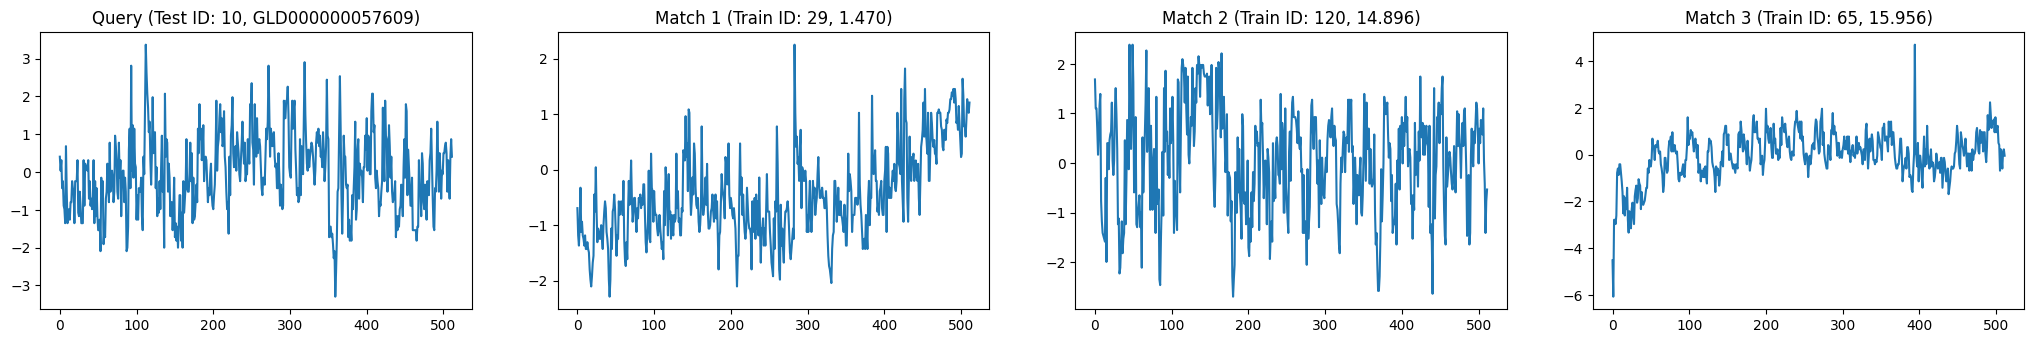

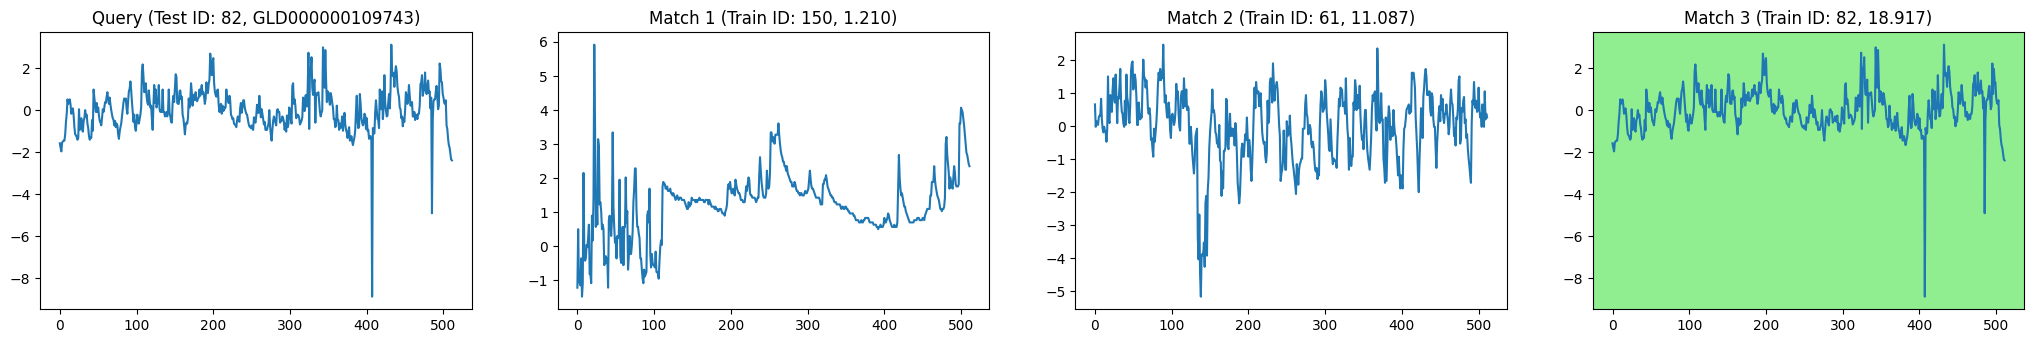

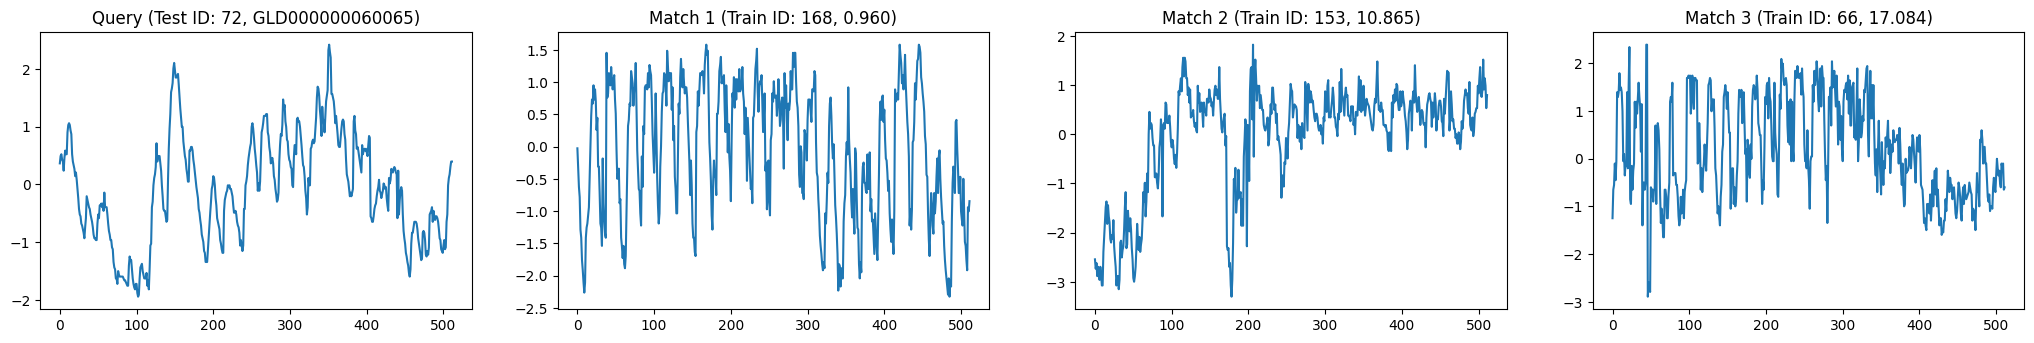

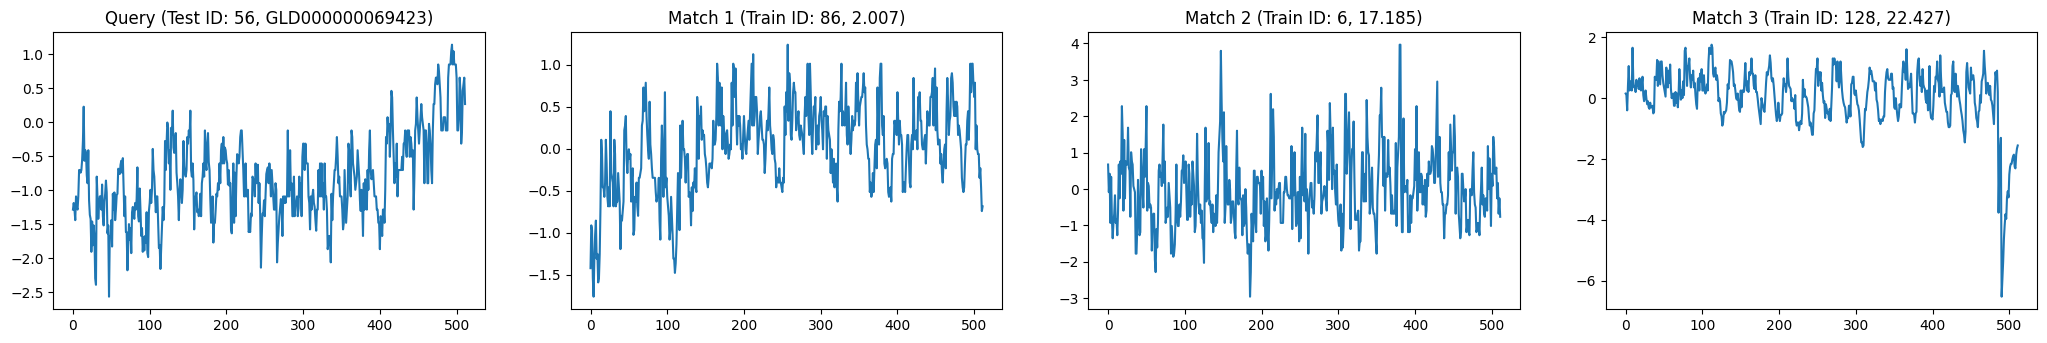

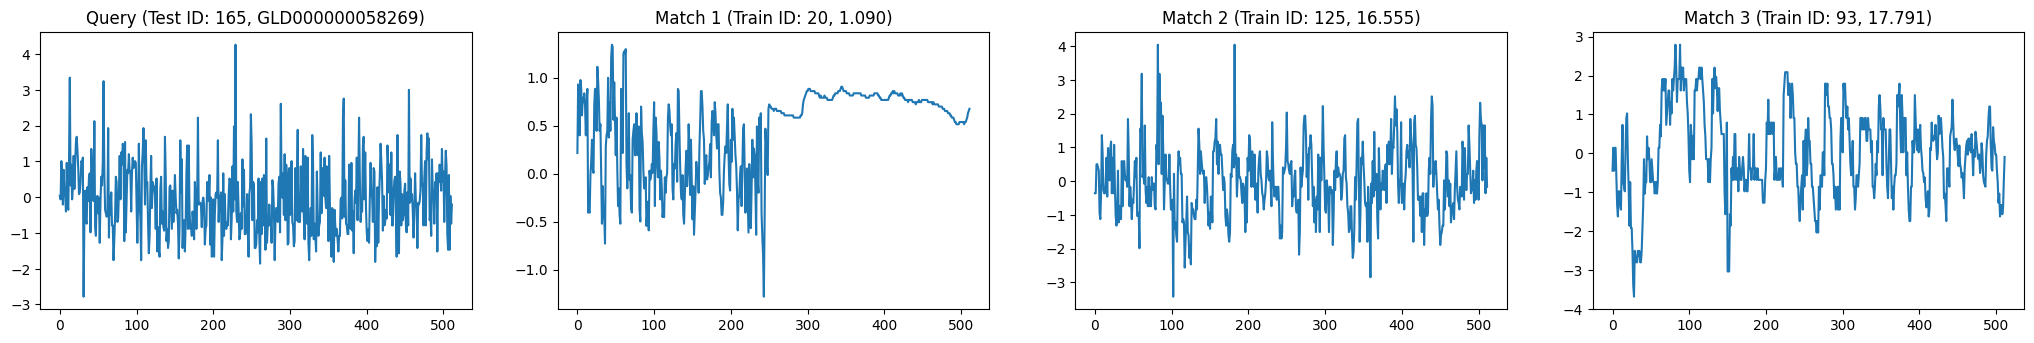

In [15]:
import matplotlib.pyplot as plt
n_plots = 5
selected_indices = np.random.choice(len(dataset), size=n_plots, replace=False).tolist()
    
# plotting loop: one query + top-k matches per selected sample
for sample_idx in selected_indices:
    neighs = I_all[sample_idx][:k]
    distances = D_all[sample_idx][:k]

    label = dataset[sample_idx]["GLD"]
    neigh_labels = [dataset[n]["GLD"] for n in neighs]

    n_cols = 1 + k
    fig, ax = plt.subplots(1, n_cols, figsize=(6.4 * n_cols, 3.6))

    # query (BRO, unseen)
    ax[0].plot(dataset[sample_idx]["bro"])
    ax[0].set_title(f"Query (Test ID: {sample_idx}, {label})")

    # predictions (DINO, seen)
    for j, (n_idx, n_label, dist) in enumerate(zip(neighs, neigh_labels, distances), start=1):
        ax[j].plot(dataset[n_idx]["dino"])
        ax[j].set_title(f"Match {j} (Train ID: {n_idx}, {dist:.3f})")
        if label == n_label: ax[j].set_facecolor("lightgreen")

### Conclusion
This pretraine model does not work very well for searching in our time-series.
Calculated precision with the different modes:
| Mode     | PREC@3 (0–1) | PREC@3 (%) |
|----------|-------------:|-----------:|
| time     | 0.009        | 0.9%       |
| full     | 0.005        | 0.5%       |
| fft      | 0.004        | 0.4%       |
| register | 0.009        | 0.9%       |

- Using `component ='backbone'` in `get_embedding()` didn't change the precision drastically. 
- The **normalization** of values (water head) also didn't impact the precision dramatically, beyond an slightly worsening the precision.
- Using 2 channels (time, water head value) didn't improve precision either. One could still try normalizing/standardizing or embeedding the time component as a channel.

One may need to fine-tune this model to improve the preformance.

## 6. Faiss search
In the notebook [tspulse_search_with_faiss](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/tspulse_search_with_faiss.ipynb) they use [faiss](https://github.com/facebookresearch/faiss) as alternative to Nearest Neighbours.

In [45]:
def evaluation(index):
    cmp, I_all, D_all = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            test_embedding = get_embeddings(model, batch['bro'], mode=mode).squeeze(axis=1)
            D, I = index.search(test_embedding, k=k)
            I_all.append(I)
            D_all.append(D)

            label_test = np.array(batch['GLD'])
            retrieved_label = np.array([[dataset[i]['GLD'] for i in neigh] for neigh in I])
            cmp.append(label_test[:, None] == retrieved_label)

    I_all = np.concatenate(I_all, axis=0)  # for visualization
    D_all = np.concatenate(D_all, axis=0) 
    cmp = np.concatenate(cmp, axis=0)
    prec_k, prec_k_each = calc_precision_k(cmp, k)
    return prec_k, prec_k_each, I_all, D_all

In [46]:
import faiss
# exact search
d = train_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(train_embeddings)
exact_prec_k, _, _, _ = evaluation(index)

# fast search
d = train_embeddings.shape[1]
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, 100)
index.train(train_embeddings)
index.add(train_embeddings)
index.nprobe = 5
prec_k, prec_k_each, I_all, D_all = evaluation(index)

print(f"[Exact search] PREC@{k}={exact_prec_k:.3f}")
print(f"[Fast search]  PREC@{k}={prec_k:.3f}")

100%|██████████| 6/6 [00:00<00:00,  8.08it/s]
WARNING clustering 190 points to 100 centroids: please provide at least 3900 training points
100%|██████████| 6/6 [00:00<00:00, 10.23it/s]

[Exact search] PREC@3=0.014
[Fast search]  PREC@3=0.014


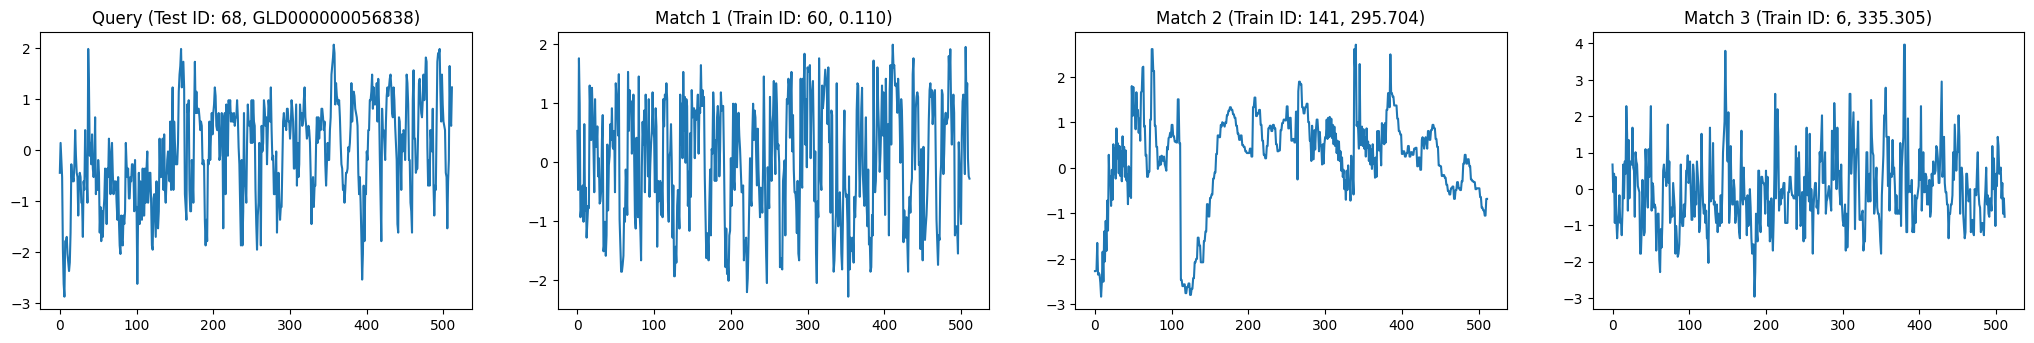

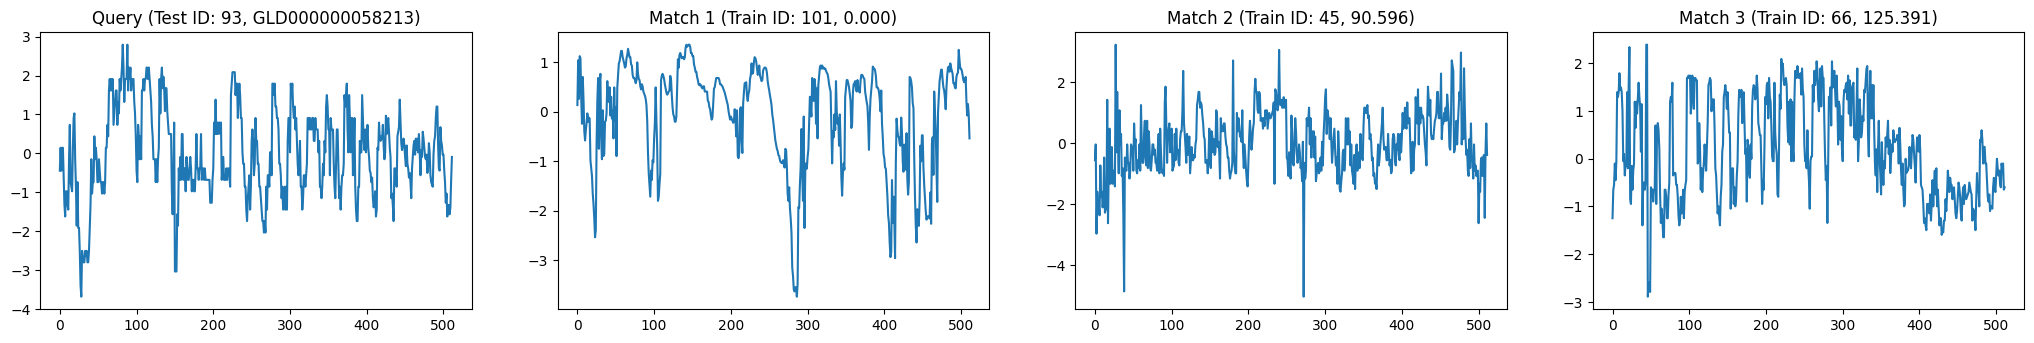

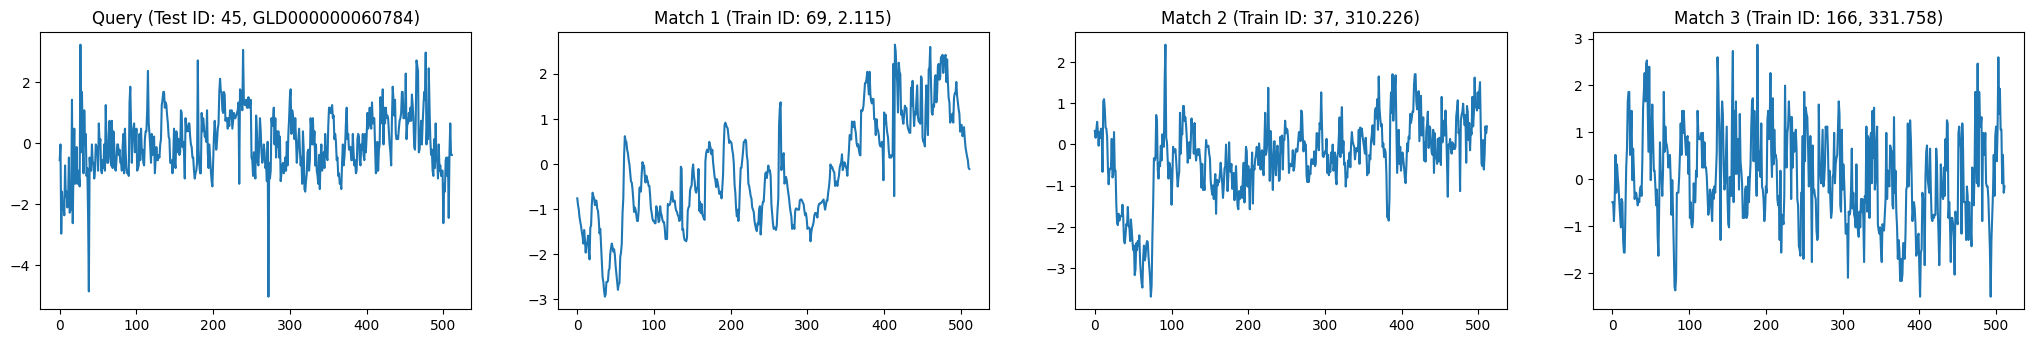

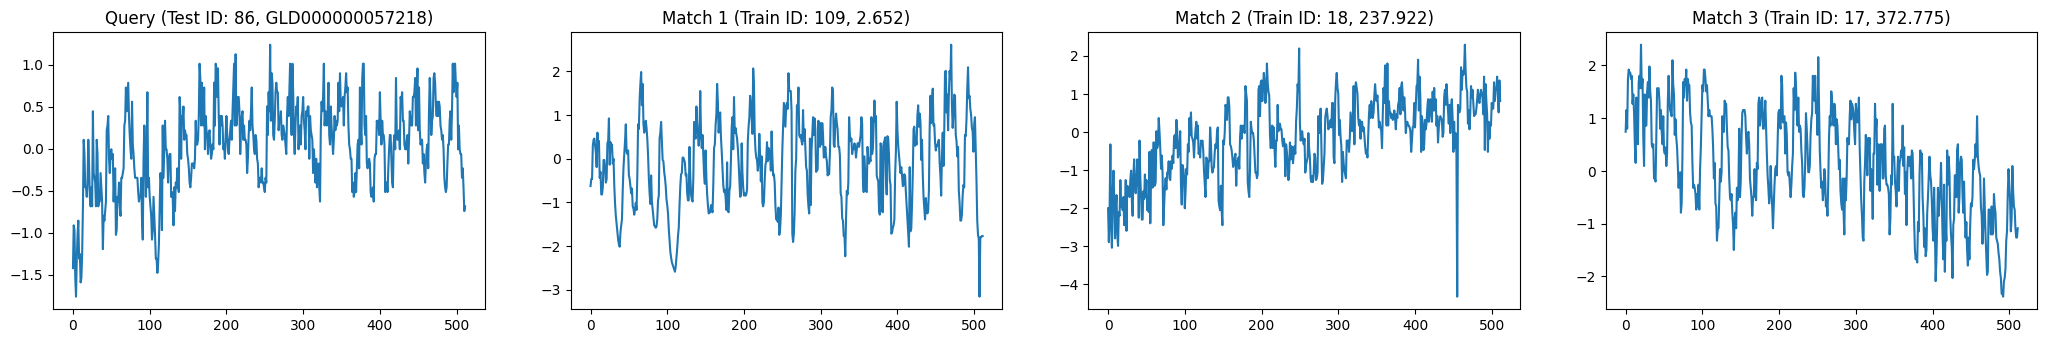

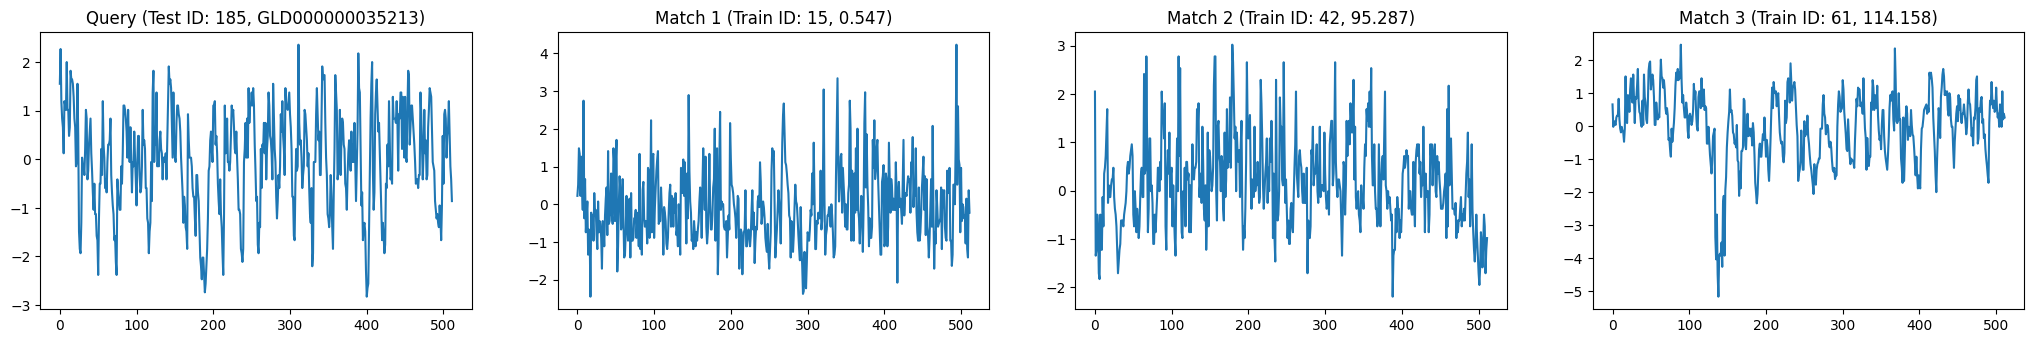

In [ ]:
import matplotlib.pyplot as plt
n_plots = 5
selected_indices = np.random.choice(len(dataset), size=n_plots, replace=False).tolist()

for sample_idx in selected_indices:
    neighs = I_all[sample_idx][:k]
    distances = D_all[sample_idx][:k]

    label = dataset[sample_idx]["GLD"]
    neigh_labels = [dataset[n]["GLD"] for n in neighs]

    n_cols = 1 + k
    fig, ax = plt.subplots(1, n_cols, figsize=(6.4 * n_cols, 3.6))

    # query (BRO, unseen)
    ax[0].plot(dataset[sample_idx]["bro"])
    ax[0].set_title(f"Query (Test ID: {sample_idx}, {label})")

    # predictions (DINO, seen)
    for j, (n_idx, n_label, dist) in enumerate(zip(neighs, neigh_labels, distances), start=1):
        ax[j].plot(dataset[n_idx]["dino"])
        ax[j].set_title(f"Match {j} (Train ID: {n_idx}, {dist:.3f})")
        if label == n_label: ax[j].set_facecolor("lightgreen")